---


# Rechnernutzung in der Physik
**Institut für Experimentelle Teilchenphysik**  
Prof. G. Quast, Dr. Th. Chwalek  
WS 2024/25 – Blatt 06

Abgabe: Mo./Di. 27./28. Januar bzw. Mo./Di. 03./04. Februar  

---

Auf diesem letzten Übungsblatt sollen viele der Konzepte und Techniken aus dem Block angewendet und
vertieft werden. In dieser Projektaufgabe sollen mit Hilfe eines Ensemble-Tests aus vielen Pseudoexperimenten (auch: Toy-MC) die Eigenschaften einer (einfachen) Parameteranpassung an einem realitätsnahen Beispiel untersucht werden. Dabei erwarten wir, dass Sie aus den Beispielen in Vorlesung und Tutorium sowie aus den weiteren hier angegebenen Tutorials und aus der Online-Dokumentation der verwendeten Software-Werkzeuge eigenständig Elemente zur Lösung der Aufgaben zusammenstellen.

Das Blatt darf innerhalb einer Tutoriumsgruppe zu maximal dritt bearbeitet werden. Die Abfrage erfolgt jedoch gleichmäßig. Jede teilnehmende Person muss in der Lage sein jeden Programmschritt vollständig erklären zu können.
**Anmerkung:** die Bearbeitung dieses Blattes ist **verpflichtend** für den Erhalt des Übungsscheins.

---
# Projektaufgabe "Ensemble-Test"
---

Gemessen werden soll die Lebensdauern von Teilchen, die nach Durchgang durch einen Detektor in einem Absorber gestoppt werden. Die Zerfälle werden über die Zerfallsprodukte wieder vom selben Detektor registriert. Die theoretische Lebensdauer der Teilchen beträgt $\tau=2\mu s$, dies entspricht in etwa der Lebensdauer des Myons. Wegen der Überlappung der Detektorsignale können Lebensdauern kleiner als $t_{\rm min}= 1 \mu s$ nicht zuverlässig gemessen werden. Die Messelektronik ist nur bis zum Zeitpunkt $t_{\rm max}= 10\mu s$ aktiv. Die Zahl der so registrierten Zerfälle ist mit $N=50$ registrierten Ereignissen nur sehr klein, so dass in einem ungebinner Maximum-Likelihood-Fit (d.h. alle Datenpunkte werden in der Likelihood-Funktion berücksichtigt, nicht nur die Einträge in Bins eines Histogramms) eine Exponentialfunktion an die im Intervall $[t_{\rm min}, t_{\rm max}]$ gemessenen Lebensdauern angepasst werden soll.

Es stellen sich zwei Fragen:
1. Ist der Schätzwert für die Lebensdauer $\hat{\tau}$ *erwartungstreu* (auch: unverzerrt, engl.: unbiased)? 
2. Wie gut ist die *Abdeckung* (engl.: coverage) des Konfidenzintervalls für $\hat{\tau}$?

**Zur Erläuterung:** Die Unsicherheit auf die gemessene Lebensdauer soll aus einem Scan der negativen Log-Likelihood (NLL) gewonnen werden. Das Intervall $[\hat{\tau}-\Delta^-, \hat{\tau}+\Delta^+]$ mit den asymmetrischen Unsicherheiten $\Delta^+$ und $\Delta^-$ heißt Konfidenzintervall. Zur Erinnerung: in der frequentistischen Statistik liegt der wahre Wert eines Parameters in einem Bruchteil $\alpha$ aller aus Daten konstruierten Konfidenzintervalle. Eine häufige Wahl ist $\alpha\approx 0,683$, dies entspricht einer Standardabweichung der Gaußverteilung. Ein wichtiger Test bei der Bestimmung von Konfidenzintervallen mithilfe von Ensemble-Tests ist die Überprüfung der Abdeckung, also die Frage, ob der wahre Wert wirklich in in einem Bruchteil $\alpha$ aller Konfidenzintervalle liegt.

**Hinweise:** Lesen Sie alle Aufgaben zuerst durch, planen Sie die Programmstruktur sorgfältig und achten Sie auf einen modularen Aufbau der einzelen Teile, damit Sie die notwendigen Schritte in einer Schleife ausführen und die gesamte Studien ggf. mit unterschiedlichen Parametereinstellungen wiederholen können. In den Codebeispielen zur Vorlesung finden Sie eine Reihe von Lösungsansätzen,
insbesondere im Jupyter-Tutorial *negLogLFits.ipynb*.


In [46]:
# notwendige Importe: numpy, matplotlib.pyplot, Fit Pakete
import numpy as np
import matplotlib.pyplot as plt
from kafe2 import UnbinnedContainer, Fit, Plot

# ->  eigenen Code hier einfügen

## Aufgaben

(1) Schreiben Sie eine Funktion, die 50 exponentiell verteilte Zufallszahlen im sensitiven Detektorintervall $[t_{\rm min}, t_{\rm max}]$ erzeugt.

In [2]:
# Parameter für die Ausführung der Studie als globale Variable
Nexp = 3000
N = 50
tau = 2.0
tmin = 1.0
tmax = 10.0

npar = 1  # Zahl der angepassten Parameter
pnams = ["tau"]  # Liste mit Namen der Parameter
true_vals = np.array([tau, tmin, tmax])  # die "Wahren Werte"

In [3]:
# definieren Sie hier die Verteilungsdichte
## def exponentialDecayPDF(t, tau= tau, tmin=tmin, tmax=tmax):

# ->  eigenen Code hier einfügen
# g
def exponential_pdf(t, t_min, t_max, tau):
	normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))
	return normalize * (1/tau) * np.exp(-t/tau)

# G
def G(t, tau):
	return 1 - np.exp(-t/tau)

# Umkehrfunk von G
def t(r, tau):
	return -tau * np.log(1-r)

In [4]:
# Funktion zur Erzeugung der Daten
## def generateExpData(N, tau, tmin, tmax):

# ->  eigenen Code hier einfügen
def generate_lifetimes(tau = tau, t_min= tmin, t_max= tmax, N= N):
	"""
	Creates N exponentially distributed random numbers between t_min and t_max
    
    Parameters:
    tau: float
		Theoretical lifetime of a particle in Mikrosec
    t_min: float
		lower boundary of the detector
    t_max: float
		upper boundary of the detector
    N: int
		number of created random numbers
	
	Return: np.array
	Array of N exponentially distributed random numbers
	"""
	r_max = G(t_max, tau)
	r_min = G(t_min, tau)

	r = np.random.uniform(r_min, r_max, N)
	return t(r, tau)

def plot_distribution(tau, t_min, t_max, N= Nexp):
	data = generate_lifetimes(tau, t_min, t_max, N)
	t_values = np.linspace(t_min, t_max, 1000)
	pdf_values = np.array([exponential_pdf(t, tmin, tmax, tau) for t in t_values])

	plt.hist(data, bins= 10, alpha= 0.6, label= 'Histogramm Daten', color='skyblue')
	plt.plot(t_values, pdf_values * len(data) *  8/10, 'r-', label= 'Exponentialverteilung')
	plt.xlabel(r'Lebensdauer t $[\mu s]$')
	plt.ylabel('Anzahl der Ereignisse')
	plt.legend()
	plt.show()


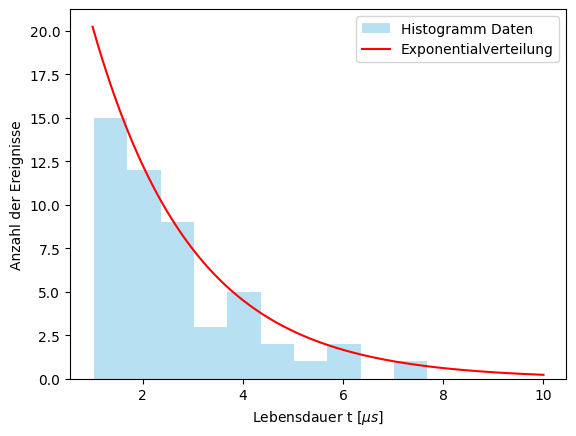

In [5]:
generated_data = generate_lifetimes()
plot_distribution( tau= tau, t_min= tmin, t_max= tmax, N= N)

(2) Setzen Sie eine Anpassung mit einer ungebinnten negativen log-Likelihood-Funktion auf.
   Dazu können Sie das Beispiel aus der Vorlesung und aus einem früheren Übungsblatt nutzen.
   Wenn Sie die Maximum-Likelihood-Anpassung nicht selbst programmieren möchten, können Sie
   entsprechenden Methoden in *kafe2* (*UnbinnedContainer*) oder die Funktion
   *PhyPraKit.phyFit.mFit()* dazu verwenden, die in der
   [PhyPraKit-Dokumentation](https://etpwww.etp.kit.edu/~quast/PhyPraKit/htmldoc/)
   beschrieben ist.

In [44]:
# Schleife zur wiederholten Ausführung von Datenerzeugung, Anpassung und zum Speichern der Ergebnisse
## def MC_loop():

# ->  eigenen Code hier einfügen
def unbinned_fit(data, t_min = tmin, t_max = tmax, report = False, plot = False):
	df = UnbinnedContainer(data)
	df.label = 'Datensatz'
	df.axis_labels = ['Lebensdauer', 'Density']
	model = exponential_pdf
	fit = Fit(data= df, model_function= model)

	fit.fix_parameter('t_max', t_max)
	fit.fix_parameter('t_min', t_min)

	fit.model_label= 'Exponential Distribution'
	fit.do_fit()
	tau = fit.parameter_values[2]
	tau_err = fit.asymmetric_parameter_errors[2]
	if plot:
		plot = Plot(fit)
		plot.plot(fit_info=True, asymmetric_parameter_errors= True)
		plt.show()
	if report:
		fit.report(asymmetric_parameter_errors= True)
	return tau, tau_err[0], tau_err[1]



C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))


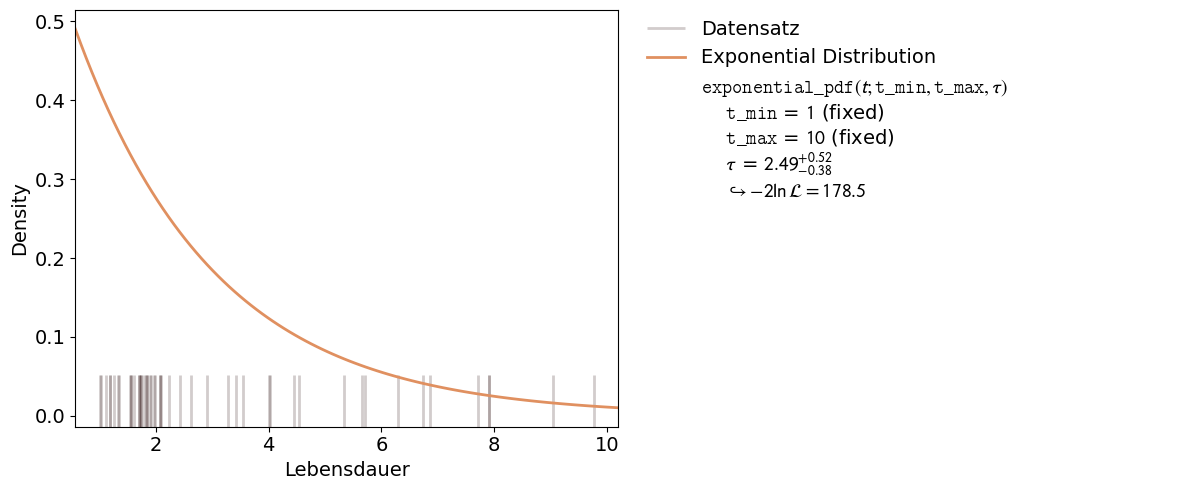

#########
# Model #
#########

    Model Function

        exponential_pdf(t; t_min, t_max, tau)

###############
# Fit Results #
###############

    Model Parameters

        t_min = 1 (fixed)
        t_max = 10 (fixed)
        tau = 2.49 + 0.52 (up) - 0.38 (down)

    Model Parameter Correlations

               t_min  t_max  tau
               =====  =====  ===
        t_min  0.0    0.0    0.0
        t_max  0.0    0.0    0.0
        tau    0.0    0.0    1.0

    Cost Function

        Cost function: negative log-likelihood

        Cost = 178.5



(np.float64(2.488923422374024),
 np.float64(-0.38480726386204334),
 np.float64(0.5249542922326468))

In [47]:

unbinned_fit(generated_data, report= True, plot= True)


(3) Führen Sie (1) und (2) in einer Schleife aus; das Ziel ist es, 3000 Pseudoexperimente zu simulieren. Beginnen Sie zum Testen des Codes aber zunächst mit einer kleineren Anzahl! Denken Sie daran, in der Schleife die zur Bestimmung von Erwartungstreue und Abdeckung notwendigen Daten in einem Array zu speichern. 

In [79]:
def MC_loop(times = 30):
	"""
	Loop to preform the experiment [input] amount of times.
	"""
	results = np.zeros((times, 3))
	for _ in range(times):
		data = generate_lifetimes()
		results[_] = unbinned_fit(data, t_min= tmin, t_max= tmax)
	return results

In [81]:
tau_measurements = MC_loop(Nexp)

C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))
C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))
C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))
C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))
C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  normalize= 1/(np.exp(-t_min/tau) - np.exp(-t_max/tau))
C:\Users\fadia\AppData\Local\Temp\ipykernel_10376\2899908605.py:7: RuntimeWarnin

(4) Analysieren Sie die in der Monte Carlo-Schleife gewonnenen Daten und geben Sie Erwartungstreue und Abdeckung für die geschätzte Lebensdauer $\hat{\tau}$ und deren Unsicherheitsintervall $[\hat{\tau}-\Delta^-, \hat{\tau}+\Delta^+]$ an. Denken Sie daran, dass Sie auch die statistische Signifikanz der so bestimmten Eigenschaften sicherstellen müssen. Schätzen Sie daher die Unsicherheiten der ermittelten Erwartungstreue und Abdeckung ab. 

In [100]:
# Berechnung und Ausgabe der Ergebnisse
# ->  eigenen Code hier einfügen

transposed_measurement = tau_measurements.transpose()
tau_mean = np.mean(transposed_measurement[0])
tau_uncert = np.zeros(2)
tau_uncert = np.mean(transposed_measurement[1]), (np.mean(transposed_measurement[2]))
print(f'Anhand der Schleife erhält man:'
	  f'tau = {tau_mean:.4f} {tau_uncert[0]:.04f} + {tau_uncert[1]:.04f}'
)

print(f'Abdeckung: [{tau_mean + tau_uncert[0]:.04f}, {tau_mean + tau_uncert[1]}]')
print(f'Verzerrung: {np.abs(tau_mean - tau):.04f}')

Anhand der Schleife erhält man:tau = 2.0154 -0.2923 + 0.3833
Abdeckung: [1.7231, 2.39866289578363]
Verzerrung: 0.0154


(5) Bewerten Sie Ihre Ergebnisse:   
    a) Wird eine statistisch signifikante Verzerrung nachgewiesen?   
    b) Ist sie ggf. im Bezug auf die Unsicherheiten der Einzelmessungen relevant?  
    c) Benötigen Sie auf Grund der festgestellten Unter- oder Überabdeckung eine Korrektur des für eine Einzelmessung relevanten Konfidenzintervalls ? 

##### Antworten

a)
Bei einer Verzerrung von 0.0154, welche geringer als die Unsicherheiten nach unten/oben, sieht man dass diese kleiner ist und somit keine Signifikanz hat.

b)
Da die Verzerrung so gering ist, würde dies in der Praxis kein Anzeichen auf einem systematischen Fehler zeigen.

c)
Da der wahre Wert von tau innerhal des Konfidenzintervalls liegt, gibt es keinen hinweis auf eine Unter- oder Überabdeckung.

(6) **Freiwillig**: In der Vorlesung haben Sie die "Bootstrap-Methode" kennen gelernt, um die Eigenschaften von Funtionen von Zufallszahlen zu untersuchen. Diese Methode lässt sich auch auf das hier behandelte Problem anwenden. Schreiben sie dazu eine Funktion, die aus einem einzigen initialen, mit der unter 1) geschriebenen Funktion erzeugten Daten neue Datensätze durch "Ziehen mit Zurücklegen" erzeugt. Dazu können Sie die Methode `rng.choice(data, size=N)` verwenden. Führen Sie nun wiederum die Schritte 2) - 4) durch und vergeleichen Sie das Ergebnis. Sie sollten diese Studie mit mehreren verschiedenen initialen Datensätzen wiederholen, da im Einzelfall, abhängig vom initialen Datensatz, größere Fluktuationen auftreten.

In [12]:
# Funktion zum Re-Sampling der Daten (für Bootstrap)
# def resampleData(N, dT0):



In [13]:
# Einen Datensatz erzeugen
# run MC loop

# Daten mit Resampling ("bootstrapping")
